This notebook provides an example of how to generate a Pourbaix Diagram using the Materials API and pymatgen. Currently, the process is a bit involved. But we are working to simplify the usage in the near future.

Author: Sai Jayaratnam

In [1]:
from pymatgen.matproj.rest import MPRester
from pymatgen.core.ion import Ion
from pymatgen import Element

from pymatgen.phasediagram.pdmaker import PhaseDiagram
from pymatgen.analysis.pourbaix.entry import PourbaixEntry, IonEntry
from pymatgen.analysis.pourbaix.maker import PourbaixDiagram
from pymatgen.analysis.pourbaix.plotter import PourbaixPlotter
from pymatgen.entries.compatibility import MaterialsProjectCompatibility, MaterialsProjectAqueousCompatibility

%matplotlib inline

Let's first define a useful function for filtering duplicate entries.

In [2]:
def contains_entry(entry_list, entry):
    for e in entry_list:
        if e.entry_id == entry.entry_id or \
            (abs(entry.energy_per_atom 
                - e.energy_per_atom) < 1e-6 and
                    entry.composition.reduced_formula ==
             e.composition.reduced_formula):
            return True

Using the Materials API, we obtain the entries for the relevant chemical system we are interested in.

In [3]:
#This initializes the REST adaptor. Put your own API key in.
a = MPRester()

#Entries are the basic unit for thermodynamic and other analyses in pymatgen.
#This gets all entries belonging to the Fe-O-H system.
entries = a.get_entries_in_chemsys(['Fe', 'O', 'H'])

To construct a Pourbaix diagram, we also need the reference experimental energies for the relevant aqueous ions. This process is done manually here. We will provide a means to obtain these more easily via a programmatic interface in future.

In [4]:
#Dictionary of ion:energy, where the energy is the formation energy of ions from 
#the NBS tables. (Source: NBS Thermochemical Tables; FeO4[2-]: Misawa T., Corr. Sci., 13(9), 659-676 (1973))
ion_dict = {"Fe[2+]":-0.817471, "Fe[3+]":-0.0478, "FeO2[2-]":-3.06055, "FeOH[+]":-2.8738,
            "FeOH[2+]":-2.37954, "HFeO2[-]":-3.91578, "Fe(OH)2[+]":-4.54022, "Fe2(OH)2[4+]":-4.84285,
            "FeO2[-]":-3.81653, "FeO4[2-]":-3.33946, "Fe(OH)3(aq)":-6.83418, "Fe(OH)2[+]":-4.54022}

#Dictionary of reference state:experimental formation energy (from O. Kubaschewski) for reference state.
ref_dict = {"Fe2O3": -7.685050670886141}
ref_state = "Fe2O3"

We will now construct the Pourbaix diagram, which requires the application of the AqueousCorrection, obtaining the stable entries, followed by generating a list of Pourbaix entries.

In [5]:
# Run aqueouscorrection on the entries

aqcompat = MaterialsProjectAqueousCompatibility()

entries_aqcorr = list()

for entry in entries:
    aq_corrected_entry = aqcompat.process_entry(entry)
    if not contains_entry(entries_aqcorr, aq_corrected_entry):
        entries_aqcorr.append(aq_corrected_entry)

# Generate a phase diagram to consider only solid entries stable in water. 
pd = PhaseDiagram(entries_aqcorr)
stable_solids = pd.stable_entries
stable_solids_minus_h2o = [entry for entry in stable_solids if 
                           entry.composition.reduced_formula not in ["H2", "O2", "H2O", "H2O2"]]
pbx_solid_entries = []
for entry in stable_solids_minus_h2o:
    pbx_entry = PourbaixEntry(entry)
    pbx_entry.g0_replace(pd.get_form_energy(entry))
    pbx_entry.reduced_entry()
    pbx_solid_entries.append(pbx_entry)

# Calculate DFT reference energy for ions (See Persson et al, PRB (2012))
ref_entry = [entry for entry in stable_solids_minus_h2o if entry.composition.reduced_formula == ref_state][0]
ion_correction = pd.get_form_energy(ref_entry)/ref_entry.composition.get_reduced_composition_and_factor()[1] - ref_dict[ref_state]
 
el = Element("Fe")
pbx_ion_entries = []
# Get PourbaixEntry corresponding to each ion
for key in ion_dict:
    comp = Ion.from_formula(key)
    factor = comp.composition[el] / (ref_entry.composition[el] / ref_entry.composition.get_reduced_composition_and_factor()[1])
    energy = ion_dict[key] + ion_correction * factor
    pbx_entry_ion = PourbaixEntry(IonEntry(comp, energy))
    pbx_entry_ion.name = key
    pbx_ion_entries.append(pbx_entry_ion)

all_entries = pbx_solid_entries + pbx_ion_entries

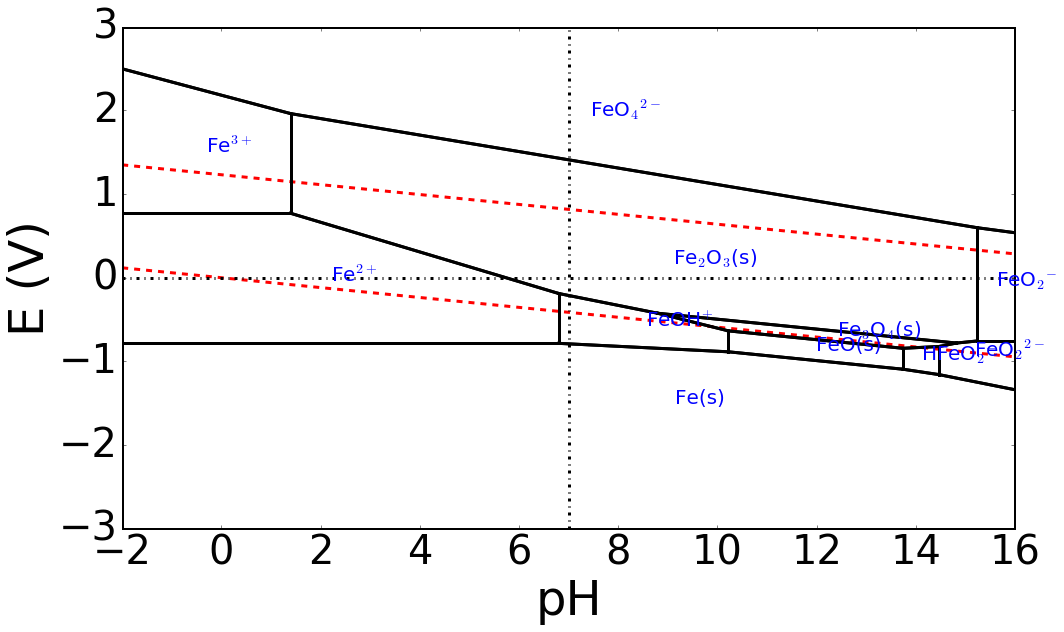

In [6]:
# Generate and plot Pourbaix diagram
pourbaix = PourbaixDiagram(all_entries)
plotter = PourbaixPlotter(pourbaix)
plotter.plot_pourbaix(limits=[[-2, 16],[-3, 3]])